In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [2]:
ames = pd.read_csv("C:/Users/mehrp/OneDrive/Documents/GitHub/PAs_7.1-7.2/AmesHousing.csv")

In [3]:
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
# No need for columns with NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

ames = ames.dropna()

In [5]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # Function of step
    make_column_selector(dtype_include=object)), # using all strings
    ("standardize", # picking the dataset
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [7]:
scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
scores.mean()

-1.4820604414081902e+20

Construct a processing sequence that incorporates every variable from the Ames dataset and applies Ridge Regression. Perform cross-validation on this sequence and assess its performance relative to standard linear regression. Afterward, train the model on the entire dataset and extract the coefficients. Finally, create a visual representation comparing these coefficients with those derived from the basic linear regression model.

In [8]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", # name of step
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # Function of step
    make_column_selector(dtype_include=object)), # Grab all strings
    ("standardize", # Choosing datasets
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

In [9]:
scores = cross_val_score(ridge_pipeline_1, X, y, cv = 5, scoring = 'r2')
scores.mean()

0.8619316345217337

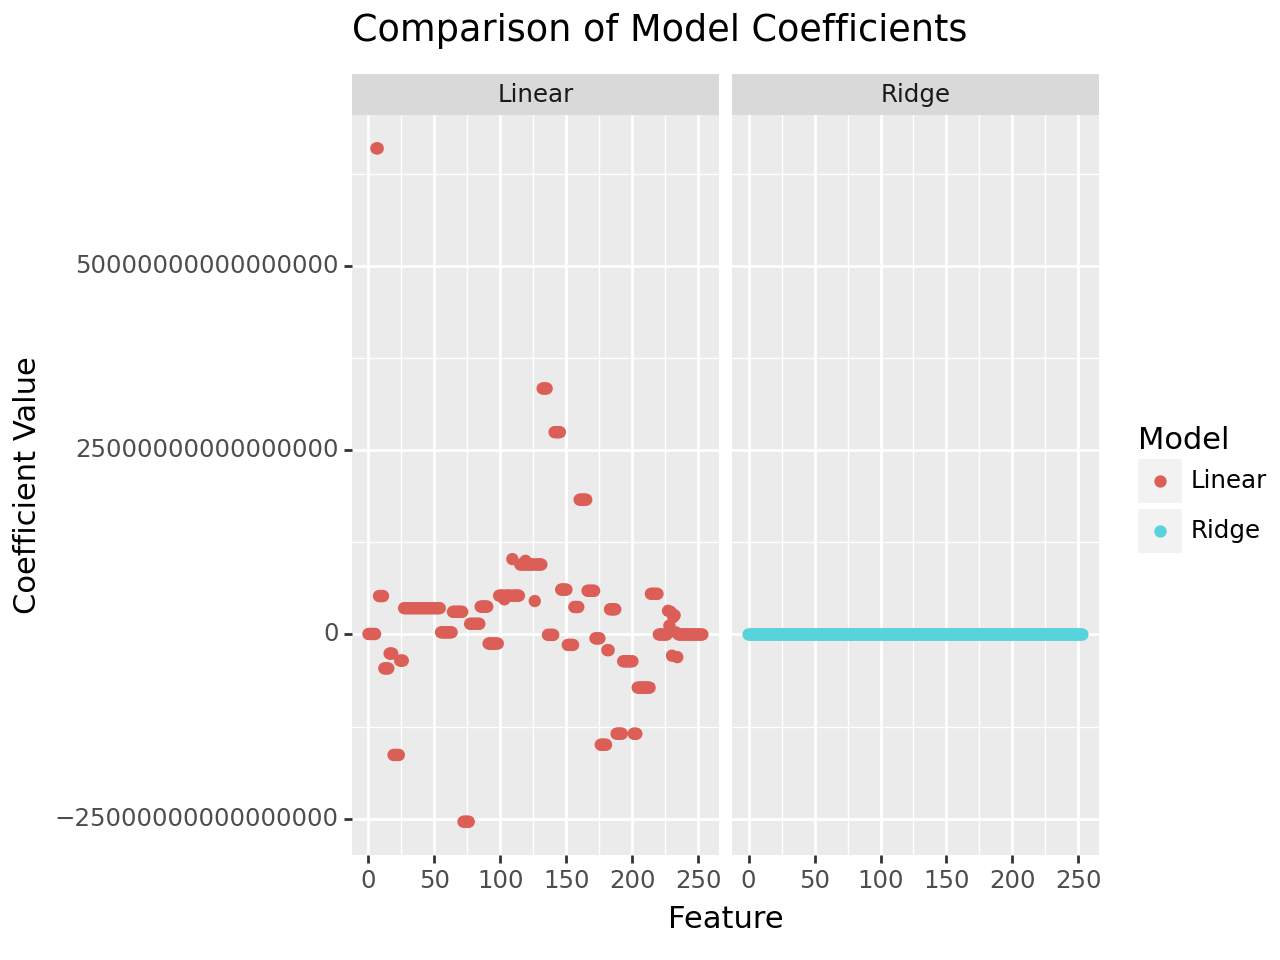

<Figure Size: (640 x 480)>

In [10]:
from plotnine import ggplot, aes, geom_point, labs, geom_bar, facet_wrap

ridge_pipeline_1.fit(X, y)
ridge_coefs = ridge_pipeline_1.named_steps['ridge_regression'].coef_

lr_pipeline_1.fit(X, y)
linear_coefs = lr_pipeline_1.named_steps['linear_regression'].coef_

coefs_df = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Linear': linear_coefs,
    'Feature': range(len(ridge_coefs))
})

coefs_df = pd.DataFrame({
    'Coefficient Value': np.concatenate((ridge_coefs, linear_coefs)),
    'Model': ['Ridge'] * len(ridge_coefs) + ['Linear'] * len(linear_coefs),
    'Feature': list(range(len(ridge_coefs))) + list(range(len(linear_coefs)))
})

# Plot using plotnine
plot = (ggplot(coefs_df, aes(x='Feature', y='Coefficient Value', color='Model')) +
        geom_point() +
        labs(x='Feature', y='Coefficient Value', title='Comparison of Model Coefficients') +
        facet_wrap('Model'))
plot

Utilize the existing pipeline and conduct optimization for the Lambda parameter. It's important to test Lambda values on a logarithmic scale. Instead of using a sequence like [1, 2, 3, 4], opt for a range such as [0.001, 0.01, 0.1, 1, 10].

In [11]:
from sklearn.model_selection import GridSearchCV

results = [.001,.01,.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipeline_1, lambdas, cv = 5, scoring='r2')

In [12]:
scores = cross_val_score(ridge_pipeline_1, X, y, cv = 5, scoring = 'r2')
scores.mean()

0.8619316345217337

Develop a LASSO pipeline and adjust the Lambda parameter accordingly. Once you've identified the optimal model, apply it to the entire Ames dataset. Then, analyze how its coefficients stack up against those obtained from Ridge Regression and OLS.

In [13]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

In [14]:
scores = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'r2')
scores.mean()

c:\Users\mehrp\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09


0.8571522175102174

The R2 score for the Ordinary Least Squares (OLS) model was notably low, thus the pipeline achieving an R2 of 0.856 evidently surpasses it. However, it doesn't quite match the performance of the Ridge regression pipeline, which boasts a slightly higher R2 of 0.861.

Construct a pipeline using Elastic Net and calibrate both the Lambda and Alpha parameters. After determining the most effective model, apply it to the complete Ames dataset. Then, proceed to evaluate and contrast the coefficients from this model with those derived from Ridge Regression and OLS.

In [15]:
elastic_pipeline = Pipeline([
    ('preprocessing', ct),
    ('elasticnet', ElasticNet())
])

In [16]:
scores = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'r2')
scores.mean()

0.8307003013529008

Given that the R2 score for the OLS model was quite low, the pipeline with an R2 of 0.831 significantly exceeds its performance. However, it does not surpass the Ridge regression pipeline, which attained a higher R2 score of 0.861.